# Lab Activity 6: Neural nets (and other things) using TensorFlow

The goal of this activity is to demo the `tensorflow` library.

This activity is adapted from two books: The code in Sections 1-3 comes from Sebastian Raschka and Vahid Mirjalili, *Python Machine Learning*, 2017, Chapter 13. (Code available [on github](https://github.com/PacktPublishing/Python-Machine-Learning-Second-Edition)). The code in Sections 4 and 5 come from Aurelien Geron, *Hands-On Machine Learning with Scikit-Learn and TensorFlow*, 2017, Chapters 9 and 10. (Also with code available [on github](https://github.com/ageron/handson-ml)).

## 1. Introduction

The `tensorflow` library was developed by Google for machine learning and other applications, such as numerical computation. In addition to Python, it has APIs in other languages. 

The central concept is a computation graph in which each node in the graph represents a computation. Let's consider an example.
Imagine a function defined by 

$$f(x,y) = x^2 y + y + 2$$

We can represent this function as a graph where each parameter ($x$ and $y$) is an input node, with nodes for each intermediate computation.
Here is our first `tensorflow` graph:

In [3]:
import tensorflow as tf
g = tf.Graph()
with g.as_default() :
    x = tf.Variable(3, name="x")
    y = tf.Variable(4, name="y")
    f = x * x * y + y + 2

In [4]:
g = tf.Graph()
with g.as_default() :
    x = tf.Variable(3, name="x")
    y = tf.Variable(4, name="y")
    f = x * x * y + y + 2


I got a deprecation warning when I ran the above code on my own laptop, but I don't know if you'll get it on the lab machines or not. If you do, ignore it. As best I can tell, there is no problem with the code above, it's just that the library functions that we're calling directly are using an out-of-date function in a lower-level library.

The `tensorflow` library has a visualization tool called TensorBoard. We can use this to look at the graph that we made. To make full use of TensorBoard we would need to modify the code to print information about the graphs (and other things like training statistics) to a log file and then start a TensorBoard server which we'd then point our browser to.
But we can shortcut all that and use the basic TensorBoard functionality using the following code. 

(Be aware, though, that this is not part of the `tensorflow` library itself but something found in the file `tensorflow_graph_in_jupyter.py` that you grabbed along with the jupyter notebook. It's part of the code that accompanies Geron's book.)

In [5]:
from tensorflow_graph_in_jupyter import show_graph
show_graph(g)

We have not executed this computation yet, just set it up as a graph. To run it, we start a `tensorflow` session:

In [6]:
sess = tf.Session(graph=g)
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)

42


Of course this seems like overkill just to compute $3^2 4 + 4 + 2$, but perhaps you can begin to see how this set up will be useful in much more complicated computations... like artificial neural nets.

Let's try something that doesn't have its input hardwired. Here we'll set up a linear function $z = w \cdot x + b$, with $x$ as formal parameter (a "placeholder" node). The names $w$ and $b$ are chosen to suggest *weight* and *bias* in a linear vector system, but we're assuming only scalars right now.

In [7]:
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(dtype=tf.float32,
                       shape=(None), name='x')
    w = tf.Variable(2.0, name='weight')
    b = tf.Variable(0.7, name='bias')

    z = w*x + b
    init = tf.global_variables_initializer()
show_graph(g)

Now we'll execute this computation graph for several input values.

In [8]:
with tf.Session(graph=g) as sess:
    ## initialize w and b:
    sess.run(init)
    ## evaluate z:
    for t in [1.0, 0.6, -1.8]:
        print('x=%4.1f --> z=%4.1f'%(
              t, sess.run(z, feed_dict={x:t})))


x= 1.0 --> z= 2.7
x= 0.6 --> z= 1.9
x=-1.8 --> z=-2.9


Having seen those two examples, let's summarize the principles. The nodes represent operations (*ops*); the incoming edges to a node correspond to that operation's operand. A *source op*---a node for a variable or constant---has no incoming edges. *Tensor* refers to the values in the computation, which are imagined to "flow" through the network. The tensors can be scalars, vectors, etc, and the Python API represents them as `numpy` arrays.

As in the examples above, there is a *construction* phase where we build a graph (and, when making a model for a machine learning application, *train* that model), and an *execution* phase where we use it. 

Now create a a graph for a numerical function of your choice, look at the visualization, and execute it for a variety of inputs.

In [9]:
import math
import tensorflow as tf
g = tf.Graph()
with g.as_default() :
    a = tf.Variable(5.0, name='a')
    b = tf.Variable(12.0, name='b')
    z = -b + t

sess = tf.Session(graph=g)
sess.run(a.initializer)
sess.run(b.initializer)
result = sess.run(z)
print(result)

show_graph(g)


-13.8


## 2. Non-scalar tensors

To explore the use of vectors and matrices in `tensorflow`, consider the code below for a graph to compute the sum and mean of each column in a *batch* of matrices. Don't think of *column* here as vertical slice of a single matrix but rather the vertical slice through a bunch of matrices laid on top of each other. In this example....

In [10]:
import numpy as np
np.arange(18).reshape(3,2,3)

array([[[ 0,  1,  2],
        [ 3,  4,  5]],

       [[ 6,  7,  8],
        [ 9, 10, 11]],

       [[12, 13, 14],
        [15, 16, 17]]])

...the values 0, 6, and 12 are in the same "column."

Here's the code. Discuss the *shape* of the input $x$ and its reshaping into $x_2$ with your partner. (Hint: `None` indicates that the size of that dimension is unspecified---in this case, the number of matrices in an input batch.)

In [11]:
import numpy as np


g = tf.Graph()
with g.as_default():
    x = tf.placeholder(dtype=tf.float32, 
                       shape=(None, 2, 3),
                       name='input_x')

    x2 = tf.reshape(x, shape=(-1, 6),
                    name='x2')

    ## calculate the sum of each column
    xsum = tf.reduce_sum(x2, axis=0, name='col_sum')

    ## calculate the mean of each column
    xmean = tf.reduce_mean(x2, axis=0, name='col_mean')
show_graph(g)

Now let's execute this on the sample set of matrices from earlier:

In [12]:
with tf.Session(graph=g) as sess:
    x_array = np.arange(18).reshape(3, 2, 3)
    print('input shape: ', x_array.shape)
    print('Reshaped:\n', 
          sess.run(x2, feed_dict={x:x_array}))
    print('Column Sums:\n', 
          sess.run(xsum, feed_dict={x:x_array}))
    print('Column Means:\n', 
          sess.run(xmean, feed_dict={x:x_array}))


input shape:  (3, 2, 3)
Reshaped:
 [[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]]
Column Sums:
 [18. 21. 24. 27. 30. 33.]
Column Means:
 [ 6.  7.  8.  9. 10. 11.]


## 3. TensorFlow for linear regression

One last thing to try out before looking at neural net applications: let's use `tensorflow` to train a model using linear regression. Here is some toy training data:

In [13]:
import matplotlib.pyplot as plt

X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1,
                    2.0, 5.0, 6.3, 
                    6.6, 7.4, 8.0, 
                    9.0])
plt.scatter(X_train, y_train,
            marker='s', s=50,
            label='Training Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 640x480 with 1 Axes>

Now we'll wrap the graph in a "`tensorflow` linear regression" class. Instead of implementing the nuts and bolts of linear regression directly, we'll use `tensorflow`'s off-the-shelf gradient-descent optimizer, giving the mean squared error as the cost function:

In [14]:
class TfLinreg(object):
    
    def __init__(self, x_dim, learning_rate=0.01,
                 random_seed=None):
        self.x_dim = x_dim
        self.learning_rate = learning_rate
        self.g = tf.Graph()
        ## build the model
        with self.g.as_default():
            ## set graph-level random-seed
            tf.set_random_seed(random_seed)
            
            self.build()
            ## create initializer
            self.init_op = tf.global_variables_initializer()
        
    def build(self):
        ## define placeholders for inputs
        self.X = tf.placeholder(dtype=tf.float32,
                                shape=(None, self.x_dim),
                                name='x_input')
        self.y = tf.placeholder(dtype=tf.float32,
                                shape=(None),
                                name='y_input')
        print(self.X)
        print(self.y)
        ## define weight matrix and bias vector
        w = tf.Variable(tf.zeros(shape=(1)),
                        name='weight')
        b = tf.Variable(tf.zeros(shape=(1)), 
                        name="bias")
        print(w)
        print(b)

        self.z_net = tf.squeeze(w*self.X + b,
                                name='z_net')
        print(self.z_net)
        
        sqr_errors = tf.square(self.y - self.z_net, 
                               name='sqr_errors')
        print(sqr_errors)
        self.mean_cost = tf.reduce_mean(sqr_errors,
                                        name='mean_cost')
        
        optimizer = tf.train.GradientDescentOptimizer(
                    learning_rate=self.learning_rate, 
                    name='GradientDescent')
        self.optimizer = optimizer.minimize(self.mean_cost)

Feel free to comment out all the print statements... I included them because they were there in the code as it appears in the Raschka book, and will allow you to trace what's going on in as we set up the graph (this doesn't train the model yet):

In [15]:
lrmodel = TfLinreg(x_dim=X_train.shape[1], learning_rate=0.01)

Tensor("x_input:0", shape=(?, 1), dtype=float32)
Tensor("y_input:0", dtype=float32)
<tf.Variable 'weight:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'bias:0' shape=(1,) dtype=float32_ref>
Tensor("z_net:0", dtype=float32)
Tensor("sqr_errors:0", dtype=float32)


Let's see the graph:

In [16]:
show_graph(lrmodel.g)

Now let's train the model. Each pass over the training data (here referred to as an *epoch*) is a `tensorflow` session. The `run` method on a session returns something with the same shape as its first parameter. In this case, the second element is the value of the cost function (mean squared error). We record those so that we can plot the cost against the epoch to see how much the cost is decreasing on each run.

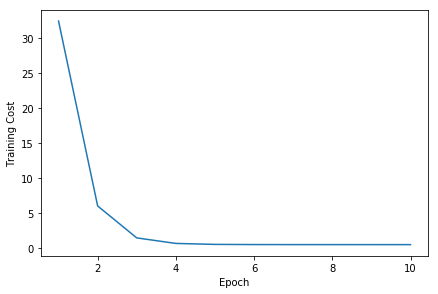

In [17]:
def train_linreg(sess, model, X_train, y_train, num_epochs=10):
    ## initialiaze all variables: W & b
    sess.run(model.init_op)
    
    training_costs = []
    for i in range(num_epochs):
        _, cost = sess.run([model.optimizer, model.mean_cost], 
                           feed_dict={model.X:X_train, 
                                      model.y:y_train})
        training_costs.append(cost)
     #   print(cost)
        
    return training_costs
sess = tf.Session(graph=lrmodel.g)
training_costs = train_linreg(sess, lrmodel, X_train, y_train)
plt.plot(range(1,len(training_costs) + 1), training_costs)
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Training Cost')
plt.show()

Now that the model is trained, let's use it to make predictions. The requires the `tensorflow` session, which we run for each new $x$ value for which we want to find a target value. Let's see how the model does compared with the training data.

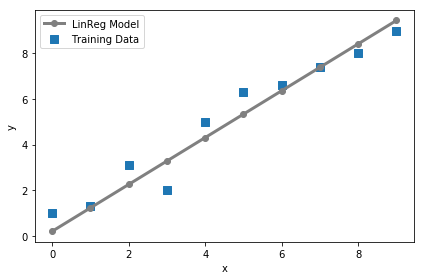

In [18]:
def predict_linreg(sess, model, X_test):
    y_pred = sess.run(model.z_net, 
                      feed_dict={model.X:X_test})
    return y_pred
plt.scatter(X_train, y_train,
            marker='s', s=50,
            label='Training Data')
plt.plot(range(X_train.shape[0]), 
         predict_linreg(sess, lrmodel, X_train),
         color='gray', marker='o', 
         markersize=6, linewidth=3,
         label='LinReg Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()

## 4. TensorFlow for neural nets

Okay, let's use `tensorflow` to build a neural net model.
First, get some training and testing data. We'll use the MNIST dataset of handwritten digits, which `tensorflow` has available through its subpackage `keras`.

In [21]:
(X_train, y_train), (X_test, y_test) = tf.keras.boston_housing.imdb.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

AttributeError: 'module' object has no attribute 'boston_housing'

In our usage of `tensorflow`, we've seen storing a `tf.Graph` instance in a variable (`g`), and we have also seen wrapping one inside of a class
(`TfLinreg`). Another option is to make new nodes that will be part of the *default graph* used by `tensorflow`. To take that approach, we'll want a convenient way to reset the graph:

In [ ]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


Now we'll set up the inputs and outputs. We also anticipate two hidden layers in a MLP that we'll build.

In [ ]:
n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
show_graph(tf.get_default_graph())

Now we make a function that generates a whole layer of perceptrons:

In [ ]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

Take time to inspect the above function, see what you can understand.

* The layer will have a name, which allows us to identify it on the TensorBoard visualization of the graph.
* How many inputs will there be to the units at this layer? That depends on the shape of X, which is the input layer...or, actually, it is the output to the previous layer, whatever layer that is.
* We make randomly generated weights. The weight matrix's shape is based on the number of units (neurons) and inputs, since each unit will have as many weights as input. The random weights are normally distributed. Look up what `tf.truncated_normal` does to find out what the *truncated* part means.
* We make biases (in class we denoted these as $w_0$), all initially 0.
* `Z` is the vector of units themselves, each doing vector multiplication (dot product), plus their bias. 
* Finally, add on the specified activation function.

Now we use this function to create a network with two hidden layers. (Having more than one hidden layer qualifies this as a *deep* learning network.) *Logit* is the name for a unit at the output layer. These have no activation function (or you can think of the activation function as being the identity).

In [ ]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name="outputs")
show_graph(tf.get_default_graph())

If you haven't noticed, a node like `dnn` above can be expanded. Click on the plus in the upper righthand corner. Explore the structure.

Now to train this network. We will use the built-in gradient descent optimizer, but first we need to define a cost (or, in this case, loss) function. This loss function used here gets into stuff we haven't covered; look up the functions in the `tensorflow` documentation for an overview.

In [ ]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

And for the training itself:

In [ ]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
show_graph(tf.get_default_graph())

Again, explore this graph by expanding the nodes.
This has set up the training. Now execute the training computation, which involves a way to evaluate the network at each step.
As explained in the Geron book:

> At each epoch, the code iterates through a number of mini-batches that > corresponds to the training set size. Each mini-batch is fetched via > > the `next_branch()` method, and then the code simply runs the training
> operation, feeding it the current mini-batch input data and targets.
> Next, at the end of the epoch, the code evaluates the model on the last > mini-atch and on the full validation set, and it prints out the result. > Finally, the model parameters are saved to disk. (Pg 271-271)

In [ ]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, "Val accuracy:", acc_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

Let's try it out:

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt") # or better, use save_path
    X_new_scaled = X_test[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)
print("Predicted classes:", y_pred)
print("Actual classes:   ", y_test[:20])

One more look at the graph:

In [ ]:
show_graph(tf.get_default_graph())

## 5. An easier way

Although marching through the details of setting up this network was (hopefully!) instructive, one doesn't need to do all that to set up and train a DNN. Instead, `tensorflow` has a higher level API. The following does largely the same thing as before, but relies on the `DNNClassifier` class. (This will take a little while.)

In [ ]:
reset_graph()
feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
dnn_clf = tf.estimator.DNNClassifier(hidden_units=[300,100], n_classes=10,
                                     feature_columns=feature_cols)

input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, num_epochs=40, batch_size=50, shuffle=True)
dnn_clf.train(input_fn=input_fn)


I haven't yet figured out how to retrieve the graph from `dnn_clf` in order to pass it to `show_graph()`. Can you?

Now evaluate this on the test set:

In [ ]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_test}, y=y_test, shuffle=False)
eval_results = dnn_clf.evaluate(input_fn=test_input_fn)
eval_results

Now it's your turn. Using the above code as a pattern, use `DNNClassifier` on a new classification problem.

In [ ]:
reset_graph()
feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
dnn_clf = tf.estimator.DNNClassifier(hidden_units=[300,100], n_classes=10,
                                     feature_columns=feature_cols)

input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, num_epochs=2, batch_size=50, shuffle=True)
dnn_clf.train(input_fn=input_fn)